In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *

from mpl_toolkits import mplot3d
%matplotlib inline

from mpl_toolkits.mplot3d import axes3d

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

from sklearn.neighbors import NearestNeighbors

import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
from vedo import *

import matplotlib.pyplot
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def random_sampling_from_pt_cloud(point_cloud, req_sample_size):
    
    point_cloud = torch.tensor(point_cloud)

    idx = np.random.randint(point_cloud.shape[0], size=req_sample_size)

    random_Sampled_point_cloud = point_cloud[idx,:]

    return random_Sampled_point_cloud

def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return sum_x/length, sum_y/length, sum_z/length

def get_clustered_batches(point_cloud, num_batches, n_neighbors_e):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors_e, algorithm='ball_tree').fit(point_cloud)
    distances, indices = nbrs.kneighbors(point_cloud)

    random_Sampled_clusters = random_sampling_from_pt_cloud(indices, num_batches)
    
    any_clustered_data = point_cloud[random_Sampled_clusters]
    
    
    return distances, indices, any_clustered_data



##for 6d point clouds

def centeroidnp_6d(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    sum_u = np.sum(arr[:, 3])
    sum_v = np.sum(arr[:, 4])
    sum_w = np.sum(arr[:, 5])
    return sum_x/length, sum_y/length, sum_z/length, sum_u/length, sum_v/length, sum_w/length 

def get_clustered_batches_6d(point_cloud, num_batches, n_neighbors_e):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors_e, algorithm='ball_tree').fit(point_cloud)
    distances, indices = nbrs.kneighbors(point_cloud)

    random_Sampled_clusters = random_sampling_from_pt_cloud(indices, num_batches)
    
    any_clustered_data = point_cloud[random_Sampled_clusters]
    
    
    return distances, indices, any_clustered_data


def get_set_of_barycenters_6d(any_clustered_data):
    
    
    barycenter_set = np.array([])

    for i in range(any_clustered_data.shape[0]):

        baryctenter = centeroidnp_6d(any_clustered_data[i])

        barycenter_set = np.concatenate((barycenter_set,baryctenter), axis = 0)

    
    barycenter_set = barycenter_set.reshape(int(barycenter_set.shape[0]/any_clustered_data.shape[2]), any_clustered_data.shape[2])
    
    return barycenter_set


#find barycenter for every batch
def get_set_of_barycenters(any_clustered_data):
    
    
    barycenter_set = np.array([])

    for i in range(any_clustered_data.shape[0]):

        baryctenter = centeroidnp(any_clustered_data[i])

        barycenter_set = np.concatenate((barycenter_set,baryctenter), axis = 0)

    
    barycenter_set = barycenter_set.reshape(int(barycenter_set.shape[0]/any_clustered_data.shape[2]), any_clustered_data.shape[2])
    
    return barycenter_set
    
    
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


def give_centeroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    sum_z = np.sum(arr[:, 2])
    return np.array([[sum_x/length, sum_y/length, sum_z/length]])

def give_next_neighbours_barycenter_indices(batch_x, input_barycenter, remaining_indices, num_neighbours):
  wasserDistance = []
  distance_cum_index = np.array([])

  for j in remaining_indices:
    
    wassDistance = dist = np.linalg.norm(batch_x[j]-input_barycenter)

    
    distance_cum_index = np.concatenate((distance_cum_index, np.array([wassDistance, j])), axis = 0)
   
  distance_cum_index = distance_cum_index.reshape(int(distance_cum_index.shape[0]/2), 2)
  distance_cum_index = sorted(distance_cum_index, key=itemgetter(0))
  
  distance_cum_index = np.array(distance_cum_index)
  
  remaining_indices = distance_cum_index[:,1]

  remaining_indices = remaining_indices.astype(int)
  
    
  A = np.array([])
  for i in range(num_neighbours):
    if(i >= distance_cum_index[:,1].shape[0]):
        break
    A = np.concatenate((A, batch_x[int(distance_cum_index[:,1][i])]), axis = 0 )
  
  A = A.reshape(int(A.shape[0]/3) , 3)

  next_barycenter = give_centeroid(A) 
  
  next_barycenter = np.array(next_barycenter)
  #print(next_barycenter.shape)
  next_barycenter = next_barycenter.reshape(next_barycenter.shape[0]* next_barycenter.shape[1])
  #print(next_barycenter.shape)  
  return A, next_barycenter, remaining_indices


def get_convergent_barycenters(point_cloud, no_neighbours, initial_pt):    
    bary = initial_pt
    rem_indices = np.array(range(0,point_cloud.shape[0]))
    #print("Size of batch : ", point_cloud.shape[0])
    sampled_barycenters = np.array([])
    sampled_barycenters = torch.tensor(sampled_barycenters)
    covered_indices = np.array([])

    for i in range(int(point_cloud.shape[0])):

        if(len(rem_indices) < 2):
            #print("END")
            break

        #print("Iteration number : ", i+1)
        #print("Input barycenter : ")


        old_bary = bary



        neighbours, bary, rem_indices = give_next_neighbours_barycenter_indices(point_cloud, bary, rem_indices, no_neighbours)



        wassDistance = np.linalg.norm(old_bary - bary)  

        covered_indices = np.concatenate((covered_indices, rem_indices[:4] ) ,axis = 0)


        #print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
        if(wassDistance == 0.0):

            unique_covered_indices = np.unique(covered_indices, axis=0)
            sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)

            s1 = set(rem_indices)
            s2 = set(unique_covered_indices)
            rem_set = s1 - s2
            rem_inds = list(rem_set)
            rem_indices = rem_set
            #print("Sampled barycenters are")
            #print(sampled_barycenters)
    sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]/3)),3)
    
    return sampled_barycenters



## Sphere in 3D

In [3]:
x, y, z = sp.symbols('x y z')
expr = x**2 + y**2 + z**2 - 1
poly = sp.Poly(expr, x, y, z)

In [4]:
expr

x**2 + y**2 + z**2 - 1

In [5]:
# convert sympy polynomial to minyterpy polynomial
newt_poly = sympy_to_mp(poly, mp.NewtonPolynomial)

In [6]:
#sample points
point_data = sample_points_on_poly(10000,        # Number of points to be sampled
                                   newt_poly,  # Polynomial in Newton basis
                                   bounds=1, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [7]:
point_data.shape

(10000, 3)

### Unclustered point cloud

In [8]:

x_so = point_data[:,0]

y_so = point_data[:,1]

z_so = point_data[:,2]


plot_points = [x_so,y_so,z_so]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

### Clustering of point cloud

In [9]:
_, _, clusters = get_clustered_batches(point_data, 50,20)

In [10]:
clusters.shape

(50, 20, 3)

### Visualising clusters formation (just illustration)


In [11]:

clusters_mix = clusters.reshape(clusters.shape[0]*clusters.shape[1],3)

print(clusters_mix.shape)


x_s = clusters_mix[:,0]

y_s = clusters_mix[:,1]

z_s = clusters_mix[:,2]



plot_points = [x_s,y_s,z_s]
Points(plot_points).show(axes=1)


(1000, 3)


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

### Centroids Calculation for clusters on sphere


In [12]:
distances, indices, clustered_data = get_clustered_batches(point_data, 200,100)

In [13]:
clustered_data.shape

(200, 100, 3)

In [14]:
set_of_barycenters = get_set_of_barycenters(clustered_data)

In [15]:
set_of_barycenters.shape

(200, 3)

In [16]:
x_b = set_of_barycenters[:,0]

y_b = set_of_barycenters[:,1]

z_b = set_of_barycenters[:,2]



plot_points = [x_b,y_b,z_b]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

### Persistent homology of barycenters: Sphere

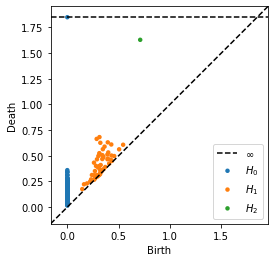

In [17]:
_,PH_diagram_barycenters = get_persistence_diagram(set_of_barycenters,2)

### comparision of Persistent homology with same number of random points from the spherical point cloud

In [18]:
random_pts = random_sampling_from_pt_cloud(point_data, 200)

/tmp/ipykernel_9757/1819769148.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


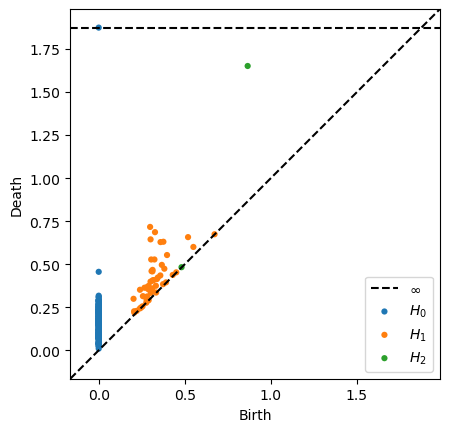

In [19]:
cur_diag, PH_diagram_rand_pts = get_persistence_diagram(random_pts, 2)

# Torus in 3D

In [20]:
## Torus
R = 1.5
r = 0.7
expr_torus = (x**2 + y**2 + z**2 + R**2 - r**2)**2 - 4*R**2*(x**2 + y**2)


In [21]:
expr_torus

-9.0*x**2 - 9.0*y**2 + 3.0976*(0.568181818181818*x**2 + 0.568181818181818*y**2 + 0.568181818181818*z**2 + 1)**2

In [22]:
poly_torus = sp.Poly(expr_torus, x, y, z)

In [23]:
sp.expand(expr_torus)

1.0*x**4 + 2.0*x**2*y**2 + 2.0*x**2*z**2 - 5.48*x**2 + 1.0*y**4 + 2.0*y**2*z**2 - 5.48*y**2 + 1.0*z**4 + 3.52*z**2 + 3.0976

In [24]:
#Convert sympy polynomial to minterpy polynomial

newt_poly_torus = sympy_to_mp(poly_torus, mp.NewtonPolynomial)

In [25]:
#Sample points on the zero isocontour

point_data_torus = sample_points_on_poly(10000,        # Number of points to be sampled
                                   newt_poly_torus,  # Polynomial in Newton basis
                                   bounds=3.0, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [26]:
point_data_torus.shape

(10000, 3)

In [27]:
x_t = point_data_torus[:,0]
y_t = point_data_torus[:,1]
z_t = point_data_torus[:,2]


plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)

ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

### Visualising torus cluster formation

In [28]:
_, _, clusters_on_torus = get_clustered_batches(point_data_torus, 100,50)

In [29]:
clusters_on_torus.shape

(100, 50, 3)

In [30]:

clusters_mix_tor = clusters_on_torus.reshape(clusters_on_torus.shape[0]*clusters_on_torus.shape[1],3)



x_t = clusters_mix_tor[:,0]

y_t = clusters_mix_tor[:,1]

z_t = clusters_mix_tor[:,2]



plot_points = [x_t,y_t,z_t]
Points(plot_points).show(axes=1)


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

### Torus Centroids of clusters

In [31]:
_, _, clustered_data_torus = get_clustered_batches(point_data_torus, 1000,100)

In [32]:
clustered_data_torus.shape

(1000, 100, 3)

In [33]:
set_of_centroids_torus = get_set_of_barycenters(clustered_data_torus)

In [34]:
set_of_centroids_torus.shape


(1000, 3)

In [35]:
x_tb = set_of_centroids_torus[:,0]

y_tb = set_of_centroids_torus[:,1]

z_tb = set_of_centroids_torus[:,2]



plot_points = [x_tb,y_tb,z_tb]
Points(plot_points).show(axes=1)


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

### Persistent homology of centroids of clusters on Torus

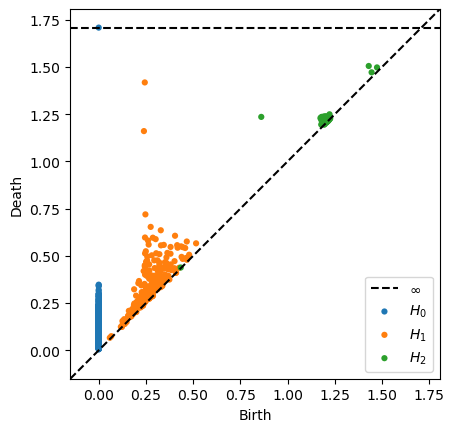

In [36]:
_, PH_diagram_torus_centroids = get_persistence_diagram(set_of_centroids_torus, 2)

### comparision of persistent homology with same number of random points from the point cloud of Torus


In [37]:
random_pts_torus = random_sampling_from_pt_cloud(point_data_torus, 1000)

In [ ]:
_, PH_diagram_torus_rand_pts = get_persistence_diagram(random_pts_torus, 2)

### Persistent homology of 6d sphere of same number of points

In [ ]:
x, y, z, u, v, w = sp.symbols('x y z u v w')
expr_6d_sp = x**2 + y**2 + z**2 + u**2 + v**2 + w**2 - 1
poly_6d_sp = sp.Poly(expr_6d_sp, x, y, z, u, v, w)

In [ ]:
expr_6d_sp

In [ ]:
# convert sympy polynomial to minyterpy polynomial
newt_poly_6d_sp = sympy_to_mp(poly_6d_sp, mp.NewtonPolynomial)

In [ ]:
newt_poly_6d_sp

In [ ]:
#sample points
point_data_6d_sp = sample_points_on_poly_multidim(1000,        # Number of points to be sampled
                                                   6,          #dimension of the space
                                                newt_poly_6d_sp,  # Polynomial in Newton basis
                                                bounds=1.0, # Boundary of the Cubic domain to be sampled
                                                tol=1e-15)  # Tolerance in solution

In [ ]:
point_data_6d_sp.shape

In [ ]:
#_, PH_diagram_6d_sphere = get_persistence_diagram(point_data_6d_sp, 2)  # not working

In [ ]:
### Clustering of 6d sphere

In [ ]:
_, _, clustered_data_6d_sphere = get_clustered_batches_6d(point_data_6d_sp, 200,100)

In [ ]:
clustered_data_6d_sphere.shape

In [ ]:
set_of_barycenters_6d_sphere = get_set_of_barycenters_6d(clustered_data_6d_sphere)

In [ ]:
set_of_barycenters_6d_sphere.shape

In [ ]:
_, PH_diagram_6d_sphere_centroids = get_persistence_diagram(set_of_barycenters_6d_sphere, 2)  # not working

# 3 d ellipsoid

In [ ]:
## Ellipsoid
a = 0.2
b = 0.5
c = 1.0
expr_ellipsoid = (x**2/a**2) + (y**2/b**2) + (z**2/c**2) - 1


In [ ]:
poly_ellipsoid = sp.Poly(expr_ellipsoid, x, y, z)


In [ ]:
#monomial by monomial

sp.expand(expr_ellipsoid)

In [ ]:
# convert sympy polynomial to minterpy polynomial

newt_poly_ellipsoid = sympy_to_mp(poly_ellipsoid, mp.NewtonPolynomial)

In [ ]:
point_data_ellipsoid = sample_points_on_poly(10000,        # Number of points to be sampled
                                   newt_poly_ellipsoid,  # Polynomial in Newton basis
                                   bounds=1.0, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [ ]:
point_data_ellipsoid.shape

In [ ]:
x_el = point_data_ellipsoid[:,0]

y_el = point_data_ellipsoid[:,1]

z_el = point_data_ellipsoid[:,2]

plot_points = [x_el,y_el,z_el]
Points(plot_points).show(axes=1)

# Cluster formation

In [ ]:
#only to get a visualization

_, _, clusters_on_ellipsoid = get_clustered_batches(point_data_ellipsoid, 100,50)

In [ ]:
clusters_on_ellipsoid.shape

In [ ]:
clusters_mix_ellipsoid = clusters_on_ellipsoid.reshape(clusters_on_ellipsoid.shape[0]*clusters_on_ellipsoid.shape[1],3)



x_el_cl = clusters_mix_ellipsoid[:,0]

y_el_cl = clusters_mix_ellipsoid[:,1]

z_el_cl = clusters_mix_ellipsoid[:,2]

plot_points = [x_el_cl,y_el_cl,z_el_cl]
Points(plot_points).show(axes=1)

# sampling the centroids

In [ ]:
_, _, clustered_data_ellipsoid = get_clustered_batches(point_data_ellipsoid, 1000,100)


In [ ]:
clustered_data_ellipsoid.shape

In [ ]:
set_of_barycenters_ellipsoid = get_set_of_barycenters(clustered_data_ellipsoid)

In [ ]:
set_of_barycenters_ellipsoid.shape

In [ ]:
plot_points = [set_of_barycenters_ellipsoid[:,0],set_of_barycenters_ellipsoid[:,1],set_of_barycenters_ellipsoid[:,2]]
Points(plot_points).show(axes=1)

# Persistent homology of ellipsoid centroids

In [ ]:
_,PH_diagram_ellipsoid_barycenters = get_persistence_diagram(set_of_barycenters_ellipsoid, 2)

### comparision with random points from the point cloud of Torus


In [ ]:
random_pts_ellipsoid = random_sampling_from_pt_cloud(point_data_ellipsoid, 1000)

In [ ]:
_, PH_diagram_rand_pts_ellipsoid = get_persistence_diagram(random_pts_ellipsoid, 2)

# Biconcave disc

In [ ]:
d = 0.5
c = 0.5
expr_disc = (d**2 + x**2 + y**2 + z**2)**3 - 8*d**2 * (y**2 + z**2) - c**4

In [ ]:
poly_disc = sp.Poly(expr_disc, x, y, z)

In [ ]:
expr_disc

In [ ]:
sp.expand(expr_disc)

In [ ]:
newt_poly_disc = sympy_to_mp(poly_disc, mp.NewtonPolynomial)

In [ ]:
point_data_disc = sample_points_on_poly(10000,        # Number of points to be sampled
                                   newt_poly_disc,  # Polynomial in Newton basis
                                   bounds=1.0, # Boundary of the Cubic domain to be sampled
                                   tol=1e-15)  # Tolerance in solution

In [ ]:
point_data_disc.shape

In [ ]:
plot_points = [point_data_disc[:,0],point_data_disc[:,1],point_data_disc[:,2]]
Points(plot_points).show(axes=1)

### clustering

In [ ]:
#visualizing clusters on disc

_, _, clustered_data_disc = get_clustered_batches(point_data_disc, 100,50)


In [ ]:
clusters_mix_disc = clustered_data_disc.reshape(clustered_data_disc.shape[0]*clustered_data_disc.shape[1],3)



x_el_cl = clusters_mix_disc[:,0]

y_el_cl = clusters_mix_disc[:,1]

z_el_cl = clusters_mix_disc[:,2]

plot_points = [x_el_cl,y_el_cl,z_el_cl]
Points(plot_points).show(axes=1)

### Sampling of centroids

In [ ]:
_, _, clustered_data_disc = get_clustered_batches(point_data_disc, 1000,100)


In [ ]:
clustered_data_disc.shape

In [ ]:
set_of_barycenters_disc = get_set_of_barycenters(clustered_data_disc)

In [ ]:
plot_points = [set_of_barycenters_disc[:,0],set_of_barycenters_disc[:,1],set_of_barycenters_disc[:,2]]
Points(plot_points).show(axes=1)

# Persistent homology of disc centroids

In [ ]:
_,PH_diagram_disc_centroids = get_persistence_diagram(set_of_barycenters_disc, 2)

### comparision of Persistent homology with same number of random points from the disc point cloud

In [ ]:
random_pts_disc = random_sampling_from_pt_cloud(point_data_ellipsoid, 1000)

In [ ]:
_, PH_diagram_rand_pts_ellipsoid = get_persistence_diagram(random_pts_disc, 2)

### plotting clusters

In [ ]:
### get c

In [ ]:
set_of_barycenters_disc = get_set_of_barycenters(clustered_data_disc)